# Group Project

Grzegorz Malisz & Tiemon Steeghs

[GitHub Repository](https://github.com/grzgm/deth-group-project)

## Context

We are focusing on creating a model that would ease and enhance the process of learning from MOOCs [Massive Open Online Courses]. The main goal of the model is to find the best learning path for user, based on user's current profile and his goal of finishing certain course. The path established by the agent should minimize the dropout possibility, learning curve and maximise the speed of learning. For our project we have picked the domain of IT MOOCs, but our solution can be extended to other topics as can be seen in the alternative courses section.

## IT MOOC

For the development purpose we have used this structure of MOOC:
   
1. Python Programming Basics
   - Python programming fundamentals

2. Database Management Essentials
   - Database management

3. Introduction to Machine Learning with Python
   - Python programming fundamentals
   - Machine learning
        
4. Web Development Using Python
   - Python programming fundamentals
   - Web development


## MDP Formal Definition

### States

Skill levels in various domains: $(s_1, s_2, \ldots, s_N)$

Defined IT skills:


1. Python Programming Fundamentals
2. Database Management
3. Machine Learning
4. Web Development

Descriptive visualisation of the state: $(Python Programming Fundamentals, Database Management, Machine Learning, Web Development)$

Later in the paper we will use the two notation, which ease understanding and writing while serving different purposes. For example, to refer to the Database Management skill level we will use $s_1$, as well as $s_{Database Management}$ notation.


### Actions
Actions are defined by taking specific courses, each course has an associated upskilling vector $u_i$ and requirement vector $r_i$. Note that if value of the certain skill in the vector is 0, it is not denoted for the sake of clarity.



#### Starting courses

1. **Python Programming Basics:**
    - **Requirements vector:**
        - $r_{\text{Python Programming Fundamentals}} = 0$
    - **Upskill vector:**
        - $u_{\text{Python Programming Fundamentals}} = 2$

2. **Database Management Essentials:**
    - **Requirements vector:**
        - $r_{\text{Python Programming Fundamentals}} = 2$
    - **Upskill vector:**
        - $u_{\text{Database Management}} = 3$

3. **Introduction to Machine Learning with Python:**
    - **Requirements vector:**
        - $r_{\text{Python Programming Fundamentals}} = 2$
    - **Upskill vector:**
        - $u_{\text{Python Programming Fundamentals}} = 3$
        - $u_{\text{Machine Learning}} = 4$
        
4. **Web Development Using Python:**
    - **Requirements vector:**
        - $r_{\text{Python Programming Fundamentals}} = 2$
    - **Upskill vector:**
        - $u_{\text{Python Programming Fundamentals}} = 3$
        - $u_{\text{Web Development}} = 3$
       
#### Advanced courses
     
1. **Advanced Python Programming and Optimization:**
    - **Requirements vector:**
        - $r_{\text{Python Programming Fundamentals}} = 3$
    - **Upskill vector:**
        - $u_{\text{Python Programming Fundamentals}} = 5$

2. **Database Administration and Performance Tuning:**
    - **Requirements vector:**
        - $r_{\text{Database Management}} = 3$
        - $r_{\text{Python Programming Fundamentals}} = 3$
    - **Upskill vector:**
        - $u_{\text{Database Management}} = 6$

3. **Deep Learning and Neural Networks with Python:**
    - **Requirements vector:**
        - $r_{\text{Python Programming Fundamentals}} = 5$
        - $r_{\text{Machine Learning}} = 3$
    - **Upskill vector:**
        - $u_{\text{Python Programming Fundamentals}} = 6$
        - $u_{\text{Machine Learning}} = 6$

4. **Full-Stack Web Development Mastery:**
    - **Requirements vector:**
        - $r_{\text{Python Programming Fundamentals}} = 4$
        - $r_{\text{Web Development}} = 4$
    - **Upskill vector:**
        - $u_{\text{Python Programming Fundamentals}} = 6$
        - $u_{\text{Web Development}} = 6$


### Transition Probabilities

Probability of passing a course is proportional to the dot product of the student's skill level and the course's requirement vector. 
- If the student passes the course, their skills are updated by $max(s, u_i)$.
- If the student fails, they might still get a slight skill improvement $max(s, (s + (u_i - s) * \beta)) $.

### Terminal State Probability

The transition probability for passing a course can be represented as:  
$$P(s, s^ \prime, a_i) = \frac{1}{1+ \exp(-\gamma r_i \cdot s)} $$

where $a_i$ is the action of taking course with requirement $r_i$ and course learning outcomes $r_i$  

The state transition for passing the course:  
$$ s^ \prime = max(s, u_i) $$

And for failing:  
$$ s^ \prime = max(s, (s + (u_i - s) * \beta)) $$

so the student will acquire the skill level from the upskill vector of the chosen course when passing, but it can never exceed it, due to the $max$ function.

The terminal state probability involves the student reaching the desired minimal skill level in all domains, leading to a reward of +1.


### Rewards

The rewards the agent recieves are based on the following factors:
- Passing or failing a course
- How long the agent is learning (cost of living)
- Achieving the requested goal

#### Passing the courses
Passing the course yields a reward of 2 for the agent to make sure the agent focusses on courses it can pass. 


#### Failing the courses
Failing the course yields a reward of 1 for the agent, since the agent can still learn a bit from failing a course.


#### Cost of living
To incentivize the agent to find the most efficient route a cost of living is taking into account. We made the decision to not implement this through states (as a budget for example) but through reward logic. Implementing this feature through states will lead to a lot more different states to calculate which is something we do not want, especially when the functionality is the same.


#### Achieving the requested goal
The agent receives a reward of 10 when it reaches the requested goal. This is to incentivize the agent to actually focus on reaching the goal, instead of just learning random courses to gain the most reward/skill.



## Implementation

### Mdp Class



In [ ]:
from math import isclose
import numpy as np

from environment_builder import EnvironmentBuilder


class Mdp:
    def __init__(self, mooc, transition_probability_gamma, alpha_state_update, beta_state_update,
                 student_learning_ability):
        # Initialise builder
        builder = EnvironmentBuilder(mooc, transition_probability_gamma, alpha_state_update, beta_state_update,
                                     student_learning_ability)
        # build MDP
        self.states, self.actions, self.transition_probabilities, self.rewards = builder.get_everything()
        # Make sure probabilities make sense
        self.inspect_probabilities()

    def possible_actions_indexes(self, state):
        return [index[0] for index, probability in np.ndenumerate(self.transition_probabilities[state]) if
                probability != 0]

    def inspect_probabilities(self):
        for state_index in range(len(self.states)):
            for action_index in range(len(self.actions)):
                probabilities_sum = sum(self.transition_probabilities[state_index, action_index, :])
                if probabilities_sum == 0:
                    continue
                else:
                    assert isclose(sum(self.transition_probabilities[state_index, action_index, :]), 1, abs_tol=1e-4)

    def step(self, current_state, action):
        probabilities = self.transition_probabilities[current_state, action]
        new_state = np.random.choice(len(probabilities), p=probabilities)
        reward = self.rewards[current_state, action, new_state]
        is_terminal = len(self.possible_actions_indexes(new_state)) == 0
        return (new_state, reward, is_terminal)


Python `Mdp` Class is used mainly for storage of the States, Actions, Transition Probabilities and Rewards. In addition, it encapsulates logic of determining next State after Agents Action, for the Q-Learning and Monte-Carlo algorithms, helper methods for determining the available Actions for Agent and guard method for inspecting Transition Probabilities, so that they add up to 1 or 0 in case of the terminal state.

The `Mdp` Class is also taking advantage of the `EnvironmentBuilder` Class to build States, Actions, Transition Probabilities and Rewards from the given input of MOOC structure and formulas written above.

The MDP is devised to work with any type of the States and Actions. It is done by assigning to each given State or Action unique Id, which is used by the MDP for all operations. This allows to store the States and Actions in the NumPy Array, to save the computation resources and allow for great extensibility. In the implementation it is done via usage of the Python Lists, which store all the Possible States and Actions and therefore assign to each unique index.

### EnvironmentBuilder Class

In [13]:
import copy
import numpy as np
import math
from itertools import product

class EnvironmentBuilder:
    def __init__(self, mooc, transition_probability_gamma, alpha, beta, student_learning_ability):
        # Hyperparameters
        self.alpha = alpha  # for state updating when passing
        self.beta = beta  # for state updating when failing
        self.student_learning_ability = student_learning_ability  # student learning ability for state updating
        self.gamma = transition_probability_gamma  # gamma parameter for calculating transition probability

        # extract data to construct the states, actions, transition_probabilities, rewards
        self.mooc = mooc
        self.skills = []
        self.max_skill_level = 0
        self.extarct_skills_and_max_skill_level()

        self.states = []
        self.actions = []
        self.transition_probabilities = None
        self.rewards = None


    # get the requirements for a given action (course)
    def get_requirement_vector(self, action):
        # Get the requirements for the given action
        action_requirements = [next((skill[1] for skill in self.mooc[action] if skill[0] == s), 0) for s in self.skills]

        return np.array(action_requirements)

    def get_student_skill(self, state):
        # Extract skill values from the state
        student_skill_levels = np.array([next(iter(skill.values())) for skill in state])
        return student_skill_levels

    def get_upskill_vector(self, action):
        # Get the upskill vector for the given action (course)
        upskill_vector = [next((skill[2] for skill in self.mooc[action] if skill[0] == s), 0) for s in self.skills]

        return upskill_vector

    def get_next_state(self, source_state, action, passed):
        # Get the upskill vector for the given action (course)
        upskill_vector = self.get_upskill_vector(action)

        # Update the state based on the action result (passing)
        new_state = copy.deepcopy(source_state)
        for idx, skill_level in enumerate(new_state):
            skill_name = list(skill_level.keys())[0]
            current_skill_level = skill_level[skill_name]

            # Check if the skill level has reached the maximum
            if current_skill_level < self.max_skill_level:
                # if the max has not been reached update the skill level based on passing or failing
                if passed:
                    new_state[idx][skill_name] = max(current_skill_level, upskill_vector[idx])
                else:
                    new_state[idx][skill_name] = max(current_skill_level + ((upskill_vector[idx] - current_skill_level) * self.beta), current_skill_level)

                # Ensure the skill level is an integer
                new_state[idx][skill_name] = math.floor(new_state[idx][skill_name])

                # if the new state exceeds the maximum skill level, set it to the maximum
                if new_state[idx][skill_name] > self.max_skill_level:
                    new_state[idx][skill_name] = self.max_skill_level

        return new_state

    def extarct_skills_and_max_skill_level(self):
        # getting every skill name from the courses and max required vector and upscale vector
        for course in self.mooc:
            for skill in self.mooc[course]:
                if skill[0] not in self.skills:
                    self.skills.append(skill[0])
                self.max_skill_level = max(self.max_skill_level, skill[1], skill[2])

    def create_states(self):
        # Generate all permutations of possible skill levels for amount of skills
        all_permutations = product(range(self.max_skill_level + 1), repeat=len(self.skills))

        # each permutaions of skill levels assign as a possible state
        for skill_levels in all_permutations:
            state = []
            for i in range(len(skill_levels)):
                state.append({self.skills[i]: skill_levels[i]})
            self.states.append(state)
        #print(self.states)

    def create_actions(self):
        # action is taking a course, so there is only need to get names of courses
        for course in self.mooc:
            self.actions.append(course)
        #print(self.actions)

    def calculate_transition_probability(self, source_state, action):
        # Retrieve the 'required vector' from the MOOC dictionary for the specific action
        required_vector = self.get_requirement_vector(action)

        # Get the student's skill levels from the source_state
        student_skill_levels = self.get_student_skill(source_state)

        # Calculate the dot product of the requirement vector and the skill level vector
        dot_product = np.dot(required_vector, student_skill_levels)

        # Calculate the probability of passing using the sigmoid function
        probability_of_passing = 1 / (1 + np.exp(-self.gamma * dot_product))

        # Probability of failing is complementary to the probability of passing
        probability_of_failing = 1 - probability_of_passing

        return probability_of_passing, probability_of_failing

    def create_transition_probabilities(self):
        # create the transition probabilities
        self.transition_probabilities = np.zeros((len(self.states), len(self.actions), len(self.states)))

        for state in self.states:
            for action in self.actions:
                # Get the transition probabilities for the given state and action
                probability_of_passing, probability_of_failing = self.calculate_transition_probability(state, action)

                # Get the next state for the given action when passing and failing
                next_state_pass = self.get_next_state(state, action, True)
                next_state_fail = self.get_next_state(state, action, False)

                # Get the index of the current state
                current_state_index = self.states.index(state)

                # Get the index of the next states
                next_state_index_pass = self.states.index(next_state_pass)
                next_state_index_fail = self.states.index(next_state_fail)

                # Get the index of the current action
                current_action_index = self.actions.index(action)

                if next_state_index_pass == current_state_index and next_state_index_fail == current_state_index:
                    continue

                # Check if the current state is a terminal state (all skills at max level)
                is_terminal_current = all(
                    state[idx][skill_name] == self.max_skill_level for idx, skill_name in enumerate(self.skills))

                # Set the transition probability for the given state, action, and next state (passing)
                self.transition_probabilities[
                    current_state_index, current_action_index, next_state_index_pass] = probability_of_passing if not is_terminal_current else 0

                # Set the transition probability for the given state, action, and current state (failing)
                self.transition_probabilities[
                    current_state_index, current_action_index, next_state_index_fail] = probability_of_failing if not is_terminal_current else 0

        # Print the transition probabilities
        # print(self.transition_probabilities)

    def manual_rewards(self):
        # Actual reward logic still needs to be added for now manual
        self.rewards = np.zeros((len(self.states), len(self.actions), len(self.states)))

        self.rewards[self.states.index([{'skillA': 1}, {'skillB': 1}, {'skillC': 1}]), self.actions.index("course3"), self.states.index(
            [{'skillA': 1}, {'skillB': 3}, {'skillC': 3}])] = 1

    def create_rewards(self):
        # Initialize the rewards array
        self.rewards = np.zeros((len(self.states), len(self.actions), len(self.states)))

        # Iterate over all states and actions
        for s_idx, source_state in enumerate(self.states):
            for a_idx, action in enumerate(self.actions):
                for ns_idx, next_state in enumerate(self.states):
                    # Check if the next state has all skill levels equal to the maximum skill level
                    if all(next_state[idx][skill_name] == self.max_skill_level for idx, skill_name in
                           enumerate(self.skills)):
                        self.rewards[s_idx, a_idx, ns_idx] = 8
                    else:
                        # Assign reward based on passing or failing, 3 for passing and 1 for failing
                        self.rewards[s_idx, a_idx, ns_idx] = 3 if self.get_next_state(source_state, action,
                                                                                      True) == next_state else 1

    def get_everything(self):
        self.create_states()
        self.create_actions()
        self.create_transition_probabilities()
        # self.manual_rewards()
        self.create_rewards()
        return self.states, self.actions, self.transition_probabilities, self.rewards

The `EnvironmentBuilder` class is used to build the MDP environment. It takes the MOOC structure as input and creates the states, actions, transition probabilities and rewards based on said structure. The class also contains helper methods to create the transition probabilities and rewards. 

The states, actions, transition probabilities and rewards are all defined based on our mathematical model. The states are defined by the skills the user has. The actions are defined by the courses the user can take. The transition probabilities are defined by the probability of passing a course. The rewards are defined by the reward the user gets for passing a course.


The output of this class, the environment, is given to the MDP class to be used in the algorithms. The actual running of the algorithms is done through the `Solver Class`, which is described in the next section. 

### Solver Class

In [14]:
import math

import numpy as np
import matplotlib.pyplot as plt


class Solver:
    def __init__(self, mdp):
        # mdp
        self.mdp = mdp

        self.action_value_array = np.zeros((len(self.mdp.states), len(self.mdp.actions)))
        self.episode_returns = []

        self.last_used_algorithm = ""
        self.last_used_parameters = {}

    def reset_solver(self):
        self.action_value_array = np.zeros((len(self.mdp.states), len(self.mdp.actions)))
        self.episode_returns = []
        self.last_used_algorithm = {}

    def solve_with_dynamic_programming(self, theta, gamma):
        self.last_used_algorithm = "dynamic programming"
        self.last_used_parameters = {
            "theta": theta,
            "gamma": gamma,
        }
        self.__dynamic_programming(theta, gamma)

    def solve_with_q_learning(self, episodes_enabled, policy_evaluation_enabled,
                              episodes, theta, max_steps_in_episode, start_state_index,
                              alpha, epsilon, gamma, cost_of_living):
        self.last_used_algorithm = "q learning"
        self.last_used_parameters = {
            "episodes_enabled": episodes_enabled,
            "policy_evaluation_enabled": policy_evaluation_enabled,
            "episodes": episodes,
            "theta": theta,
            "max_steps_in_episode": max_steps_in_episode,
            "start_state_index": start_state_index,
            "alpha": alpha,
            "epsilon": epsilon,
            "gamma": gamma,
            "cost_of_living": cost_of_living
        }

        if episodes_enabled:
            for episode in range(episodes):
#                 print(f"q_learning episode: {episode}")
                self.__q_learning(max_steps_in_episode, start_state_index, alpha, epsilon, gamma, cost_of_living)

        # policy evaluation
        episode = 0
        if policy_evaluation_enabled:
            while True:
                episode += 1
#                 print(f"q_learning iteration: {episode}")

                difference = self.__q_learning(max_steps_in_episode, start_state_index, alpha, epsilon, gamma, cost_of_living)
                if difference < theta:
                    break

    def solve_with_monte_carlo(self, episodes_enabled, policy_evaluation_enabled,
                               episodes, theta, max_steps_in_episode, start_state_index,
                               alpha, epsilon, gamma, cost_of_living):
        self.last_used_algorithm = "monte carlo"
        self.last_used_parameters = {
            "episodes_enabled": episodes_enabled,
            "policy_evaluation_enabled": policy_evaluation_enabled,
            "episodes": episodes,
            "theta": theta,
            "max_steps_in_episode": max_steps_in_episode,
            "start_state_index": start_state_index,
            "alpha": alpha,
            "epsilon": epsilon,
            "gamma": gamma,
            "cost_of_living": cost_of_living
        }

        if episodes_enabled:
            for episode in range(episodes):
#                 print(f"monte_carlo episode: {episode}")
                self.__monte_carlo(max_steps_in_episode, start_state_index, alpha, epsilon, gamma, cost_of_living)

        # policy evaluation
        episode = 0
        if policy_evaluation_enabled:
            while True:
                episode += 1
#                 print(f"monte_carlo iteration: {episode}")

                difference = self.__monte_carlo(max_steps_in_episode, start_state_index, alpha, epsilon, gamma, cost_of_living)
                if difference < theta:
                    break

    def __dynamic_programming(self, theta, gamma):
        # policy evaluation
        episode = 0
        while True:
#             print(f"episode: {episode}")
            difference = 0
            for state in range(len(self.mdp.states)):
                for action in range(len(self.mdp.actions)):
                    old_value = self.action_value_array[state, action]
                    new_value = 0
                    for new_state in range(len(self.mdp.states)):
                        new_value += self.mdp.transition_probabilities[state, action, new_state] * (
                                self.mdp.rewards[state, action, new_state] + gamma * self.action_value_array[
                            new_state, np.argmax(self.action_value_array[new_state, :])])
                    self.action_value_array[state, action] = new_value
                    difference = max(difference, abs(old_value - new_value))
            if difference < theta:
                break

    def __q_learning(self, max_steps_in_episode, start_state_index, alpha, epsilon, gamma, cost_of_living):
        # start episode
        difference = 0
        episode_return = 0
        previous_state = start_state_index
        for step in range(max_steps_in_episode):
            best_action = np.argmax(self.action_value_array[previous_state, :])
            possible_actions = self.mdp.possible_actions_indexes(previous_state)

            # choose action based on epsilon-greedy policy
            # np.max(action_value_array[previous_state, :]) is there to balance starting states
            # when action_value_array is full of zeros and agent always goes with action with index 0
            # so agent chooses random action
            if np.random.rand() < epsilon or not np.max(
                    self.action_value_array[previous_state, :]) or best_action not in possible_actions:
                # random action
                action = np.random.choice(self.mdp.possible_actions_indexes(previous_state))
            else:
                # best action
                action = best_action

            old_value = self.action_value_array[previous_state, action]
            new_value = 0

            # make an action
            new_state, reward, is_terminal = self.mdp.step(previous_state, action)

            # take cost of living into account
            if cost_of_living != 0:
                reward += cost_of_living

            episode_return += reward

            # update Action Value function (Q)
            new_value = (1 - alpha) * self.action_value_array[
                previous_state, action] + alpha * (
                                reward + gamma * max(self.action_value_array[new_state, :]))
            self.action_value_array[previous_state, action] = new_value

            previous_state = new_state

            # if new state is terminal finish episode
            if is_terminal:
                break

            difference = max(difference, abs(old_value - new_value))

        self.episode_returns.append(episode_return)
        return difference

    def __monte_carlo(self, max_steps_in_episode, start_state_index, alpha, epsilon, gamma, cost_of_living):
        # start episode
        monte_carlo_history = []
        previous_state = start_state_index
        for step in range(max_steps_in_episode):
            best_action = np.argmax(self.action_value_array[previous_state, :])
            possible_actions = self.mdp.possible_actions_indexes(previous_state)

            # choose action based on epsilon-greedy policy
            # np.max(action_value_array[previous_state, :]) is there to balance starting states
            # when action_value_array is full of zeros and agent always goes with action with index 0
            if np.random.rand() < epsilon or not np.max(
                    self.action_value_array[previous_state, :]) or best_action not in possible_actions:
                # random action
                action = np.random.choice(self.mdp.possible_actions_indexes(previous_state))
            else:
                # best action
                action = best_action

            # make an action
            new_state, reward, is_terminal = self.mdp.step(previous_state, action)

            # take cost of living into account
            if cost_of_living != 0:
                reward += cost_of_living

            # add the episode states, actions, rewards for  Monte Carlo
            monte_carlo_history.append((previous_state, action, reward))

            previous_state = new_state

            # if new state is terminal finish episode
            if is_terminal:
                break

        # Calculate returns and update Action Value function (Q)
        difference = 0
        episode_return = 0
        for t in range(len(monte_carlo_history) - 1, -1, -1):
            state = monte_carlo_history[t][0]
            action = monte_carlo_history[t][1]
            reward = monte_carlo_history[t][2]

            old_value = self.action_value_array[state, action]
            new_value = self.action_value_array[state, action]

            episode_return = gamma * episode_return + reward
            new_value += alpha * (episode_return - self.action_value_array[state, action])
            self.action_value_array[state, action] = new_value

            difference = max(difference, abs(old_value - new_value))

        self.episode_returns.append(episode_return)
        return difference

    def create_plot_of_action_value_array(self):
        # Set the figure size
        plt.figure(figsize=(8, math.ceil(len(self.mdp.states) * 0.24)))

        # Create a heatmap
        plt.imshow(self.action_value_array, cmap='viridis', interpolation='nearest', aspect=0.2)

        # Add colorbar
        plt.colorbar()

        # Set axis labels
        plt.xlabel('Actions')
        plt.ylabel('States')

        # Set custom labels for the x-axis
        plt.xticks(np.arange(len(self.mdp.actions)), self.mdp.actions)

        # Set custom labels for the y-axis
        plt.yticks(np.arange(len(self.mdp.states)), self.mdp.states)

        # Annotate each cell with its value
        for i in range(len(self.mdp.states)):
            for j in range(len(self.mdp.actions)):
                plt.text(j, i, f'{self.action_value_array[i, j]:.2f}', ha='center', va='center', color='w')

        # Display the plot
        plt.title('Action-Value Array')
        plt.suptitle(
            f'Algorithm: {self.last_used_algorithm}')
        plt.show()

    def create_plot_of_episode_returns(self):
        # Set the figure size
        plt.figure(figsize=(10, 7))

        # Create a plot
        plt.plot(self.episode_returns)

        # Add labels to the plot
        plt.xlabel('Episode Number')
        plt.ylabel('Return')
        plt.title('Plot of Episode Returns')
        plt.suptitle(
            f'Algorithm: {self.last_used_algorithm}')

        legend_text = "\n".join(map(lambda p: f"{p}: {self.last_used_parameters[p] !s}", self.last_used_parameters))
        plt.legend([legend_text], loc='upper left', bbox_to_anchor=(0.7, 0.9))

        # Display the plot
        plt.show()


`Solver Class` is used to structure and make accessible algorithms for finding the Optimal Policy. It works based on the data stored in the `Mdp` Class and consists of implementation of Dynamic Programming, Q-Learning and Monte-Carlo. Q-Learning and Monte-Carlo are implemented with two operation modes: based on fixed amount of episodes or until Policy has Converged.

The `Solver Class` is also responsible for generating the plots of the Action Value Function and Episode Returns. Each plot has visible Algorithm and Parameters used to obtain data, which allows for easy reruns of Algorithms and straightforward testing Algorithm performance.

`Solver Class` is mainly used with combination of three steps:
1. Resetting Solver to the initial values,
2. Running selected Algorithm with given values,
3. Displaying Plots.

## Algorithms

For the purpose of solving the problem we have implemented 3 different algorithms:

- Dynamic Programming,
- Q-Learning,
- Monte-Carlo.

Algorithms can be categorized based on their knowledge of transition probability. Dynamic Programming uses knowledge of all transition probabilities, where Q-Learning and Monte-Carlo work based on the data provided from mdp (states, actions, rewards).

In addition, to standard implementation of Q-Learning and Monte-Carlo with the Epsilon exploration, the guards for starting stage of algorithms were introduced, as if all Actions in the current state have Action Value of 0, the Agent chooses random Action instead of always first one.
`not np.max(self.action_value_array[previous_state, :])`

### Testing Course

For the testing of our algorithms we have nog used the created IT MOOC since this would take too long to run. Instead we have created a simple MOOC with 4 courses and 3 skills. The MOOC is defined in the following dictionary:

In [15]:
# Example MOOC Dictionary
mooc = {
        "course1": [["skillA", 0, 1], ["skillB", 0, 1]],
        "course2": [["skillA", 0, 0], ["skillC", 0, 1]],
        "course3": [["skillB", 1, 2], ["skillC", 1, 2]],
        "course4": [["skillA", 1, 2], ["skillC", 1, 2]]
}

# hyperparameters environment builder
transition_probability_gamma = 0.1
alpha_state_update = 5
beta_state_update = 0.05
student_learning_ability = 1

# states, actions, transition_probabilities, rewards = builder()
mdp = Mdp(mooc, transition_probability_gamma, alpha_state_update, beta_state_update,
          student_learning_ability)

solver = Solver(mdp)



### Dynamic Programming

It is controlled by the variable `dynamic_programming_enabled` and does the Policy Evaluation and Policy Improvement to compute the Action Value Function based on the Greedy Policy with respect to Action Value Function, by implementation of the Bellman Equation:

$$
q_{\pi}(s,a)=\sum_{^{s^ \prime \in S}_{r \in R}} p(s^ \prime, r | s, a)[r + \gamma \sum_{a^ \prime \in A(s^ \prime)} \pi(a^ \prime | s^ \prime)q_{\pi}(s^ \prime | a^ \prime)]
$$

The $\sum_{a^ \prime \in A(s^ \prime)} \pi(a^ \prime | s^ \prime)q_{\pi}(s^ \prime | a^ \prime)$ inside the code is solved by usage of `action_value_array[new_state, np.argmax(action_value_array[new_state, :])]`, as the Greedy Policy chooses only one action, not any other, which means that in probabilities given by $\pi(a^ \prime | s^ \prime)$ they compose only of 0 and one 1, thus resulting in multiplying most of the values from the Action Value Function by 0. In order to omit unnecessary computation only the value of Action Value Function for the Action with probability of 1 is present.

#### Policy Evaluation

After each sweep through the Action Value Function the algorithm inspects whether maximal difference between old and new value is smaller than threshold `theta`, which indicates that the optimal Action Value Function for given policy has been found. Process stops repeating when the Policy has Converged.

#### Policy Improvement / Policy Extraction

Policy Improvement is done somewhat automatically, as the Policy is not stored, but is always calculated with the usage of `argmax()` function, which always returns Optimal Greedy Policy with respect to current Action Value Function.

#### Algorithm's Performance

Plots below showcase Algorithm Performance visualizing Action Value Function and Episode Returns. In the results you can see the performance of the Dynamic Programming algorithm with the test MOOC course. If we look at the heatmap of the Action Value Function you can see the most optimal actions the algorithm has found in a given state.

Since most courses can still lead to a small skill gain, at the starting state you can see the it does not matter to much which course is picked. However, if we look at the state ${ SkillA = 1, SkillB = 2, SkillC =2 }$ Then you can see that course 4 is clearly the most optimal course to take. This makes sense since it is the only course that can still lead to a skill gain in ${SkillA}$, and thus, reach the goal. 


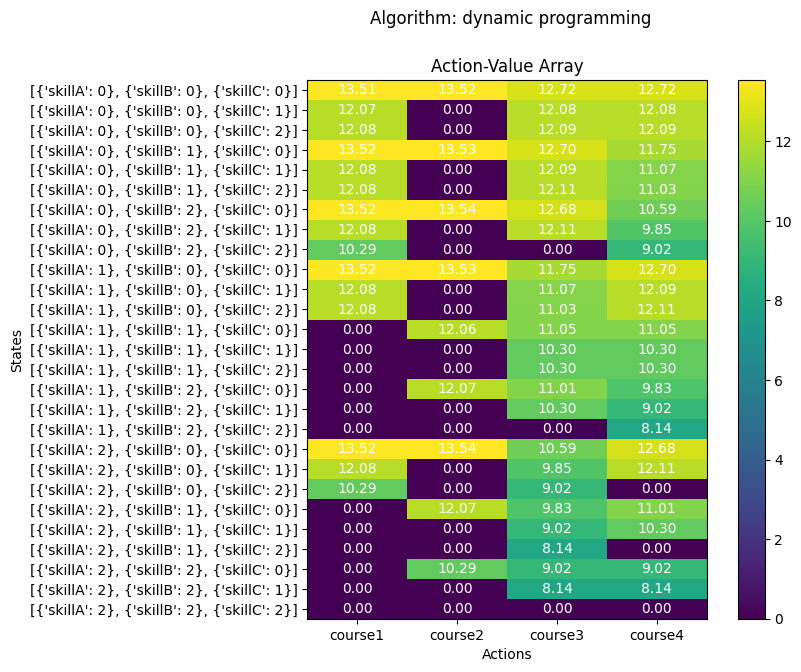

In [16]:
# dynamic programming
solver.solve_with_dynamic_programming(theta=0.000001, gamma=0.9)
solver.create_plot_of_action_value_array()

### Q-Learning

It is controlled by the variable `q_learning_enabled` and evaluates the Action Value Function every step of the agent. Algorithm inspects whether maximal difference between old and new value is smaller than threshold `theta`, which indicates that the optimal Action Value Function for given policy has been found. Process stops repeating when the Policy has Converged. Exploration rate of the Agent is controlled through `epsilon` parameter, which decides the probability of making random decision by Agent. Q-Learning Evaluation formula:

$$
Q({s}, {a}) \gets (1 - \alpha) * Q({s}, {a}) + \alpha * (R + \gamma * maxQ({s}^ \prime, {a}^ \prime))
$$ 

#### Algorithm's Performance

Plots below showcase Algorithm Performance visualizing Action Value Function and Episode Returns. We have tested the Q-learning algorithm with 2 different sets of parameters. One introduces a cost of living and has random exploration enabled and the other one does not. The results of the algorithm can be seen in the plots below. 

If we take a look at the heatmaps, we can see that both q-learning instances seem to clearly find the best order of actions if we look at the Action Value Function. However, the graphs tell us a different story. The graphs show very noisy output and it is hard to see how well the algorithm is learning. This might be caused by the limited amount of courses available in the test MOOC. 

We do see a clear difference in the heatmaps with the random exploration turned on or off. With the random exploration turned on, the algorithm seems to explore more and thus, the Action Value Function is more spread out. This is also visible in the heatmaps, where the algorithm with random exploration turned on seems to learn different options and what value they are expected to yield.


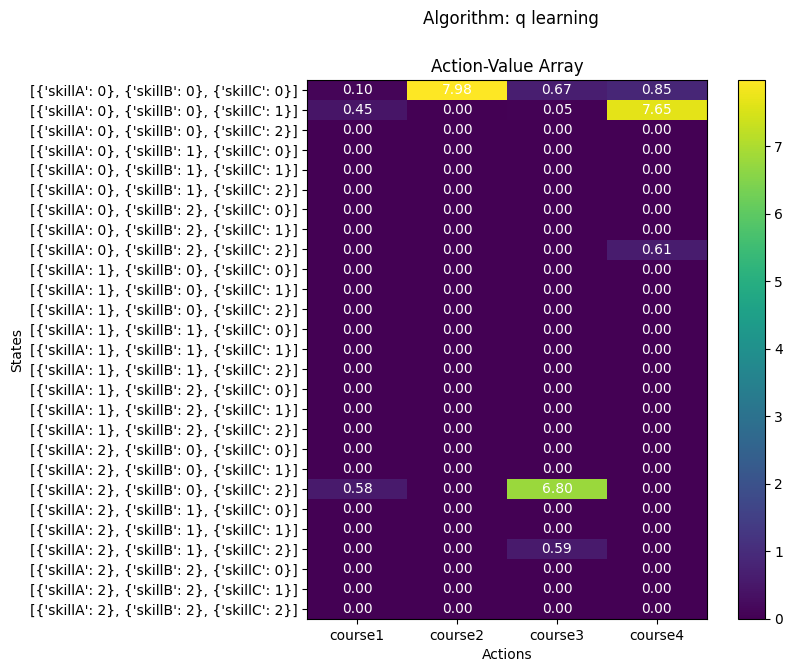

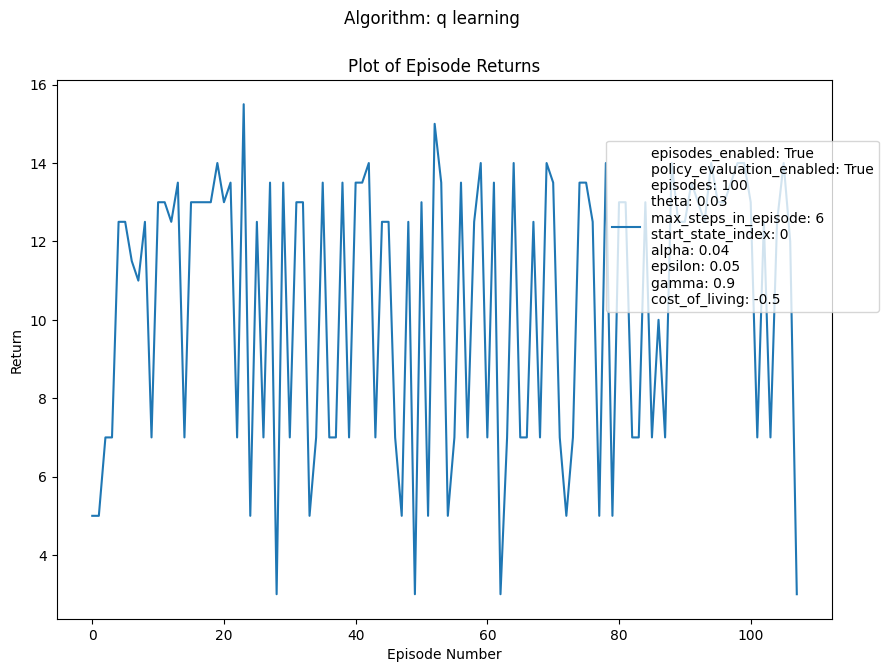

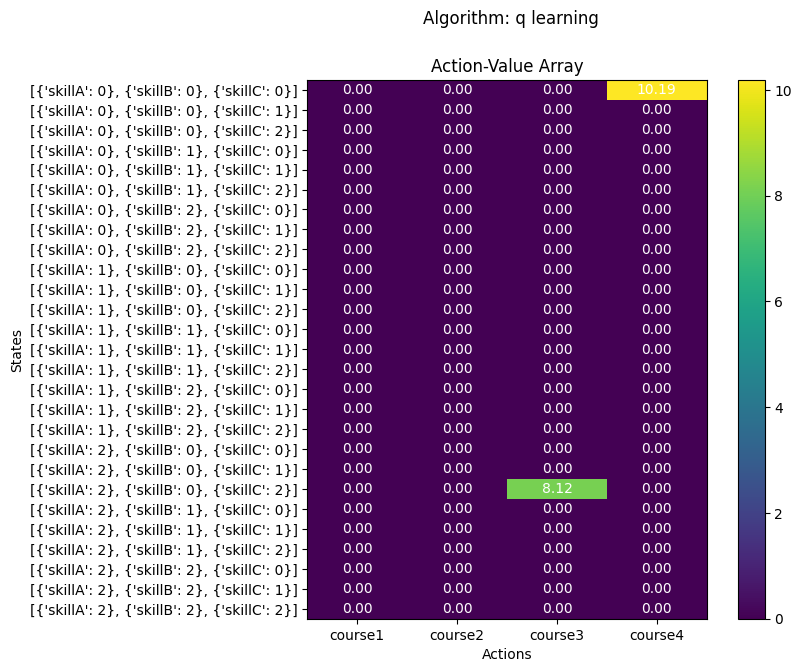

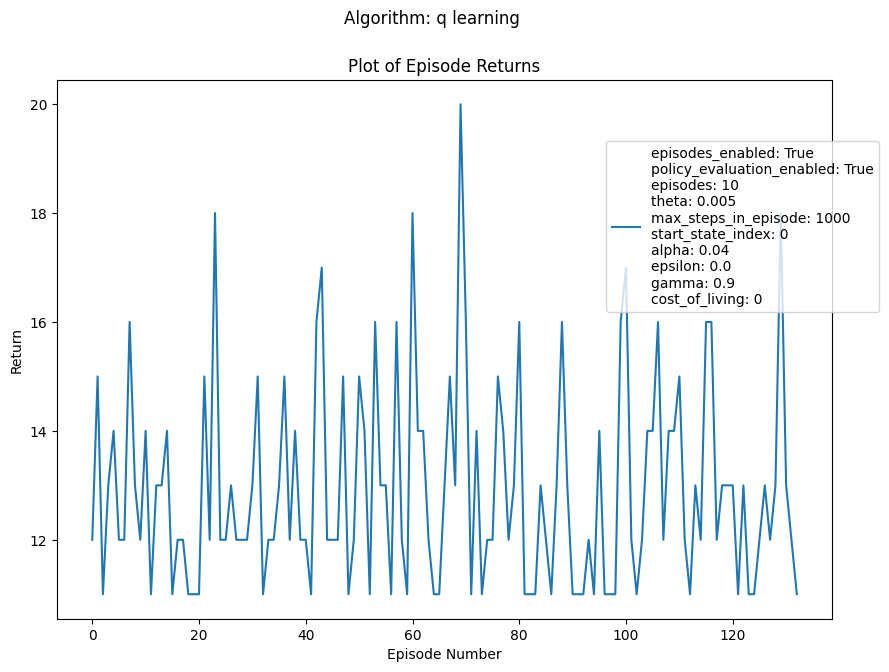

In [19]:
# q-learning
solver.reset_solver()
solver.solve_with_q_learning(True, True,
                             episodes=100,
                             theta=0.03,
                             max_steps_in_episode=6,
                             start_state_index=0,
                             alpha=0.04,
                             epsilon=0.05,
                             gamma=0.9,
                             cost_of_living=-0.5
                             )
solver.create_plot_of_action_value_array()
solver.create_plot_of_episode_returns()

solver.reset_solver()
solver.solve_with_q_learning(True, True,
                             episodes=10,
                             theta=0.005,
                             max_steps_in_episode=1000,
                             start_state_index=0,
                             alpha=0.04,
                             epsilon=0.00,
                             gamma=0.9,
                             cost_of_living=0
                             )
solver.create_plot_of_action_value_array()
solver.create_plot_of_episode_returns()


### Monte-Carlo

It is controlled by the variable `monte_carlo_enabled`. During the episode of the Agent, a history of choices is recorded, and after the episode finishes the Action Value Function is evaluated, by analysing the Agent path from the end to the beginning. Algorithm inspects whether maximal difference between old and new value is smaller than threshold `theta`, which indicates that the optimal Action Value Function for given policy has been found. Process stops repeating when the Policy has Converged. Exploration rate of the Agent is controlled through `epsilon` parameter, which decides the probability of making random decision by Agent. Monte-Carlo Evaluation formula:

$$
Q({s}^m_t, {a}^m_t) \gets Q({s}^m_t, {a}^m_t) + \alpha ({g}^m_t - Q({s}^m_t, {a}^m_t))
$$

#### Algorithm's Performance

Plots below showcase Algorithm Performance visualizing Action Value Function and Episode Returns. The monte carlo algorithm seems to perform very similar to the Q-learning algorithm without random exploration or a cost of living. The heatmap shows the same order of picking courses the reach the end goal.

The graph of monte carlo is different to that of the Q-learning algorithms though, it shows somewhat of a learning curve. The graph is still a bit noisy but alot clearer then the Q-learning graphs.


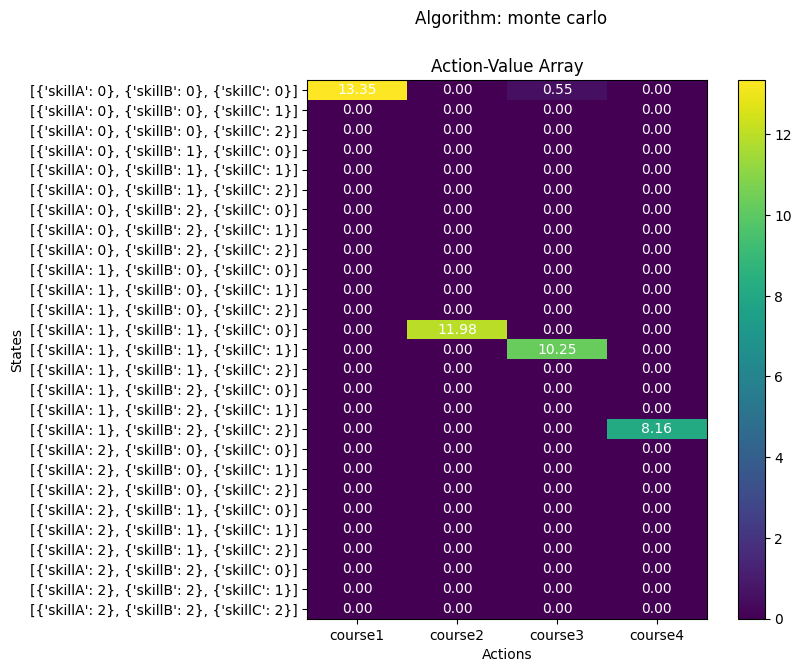

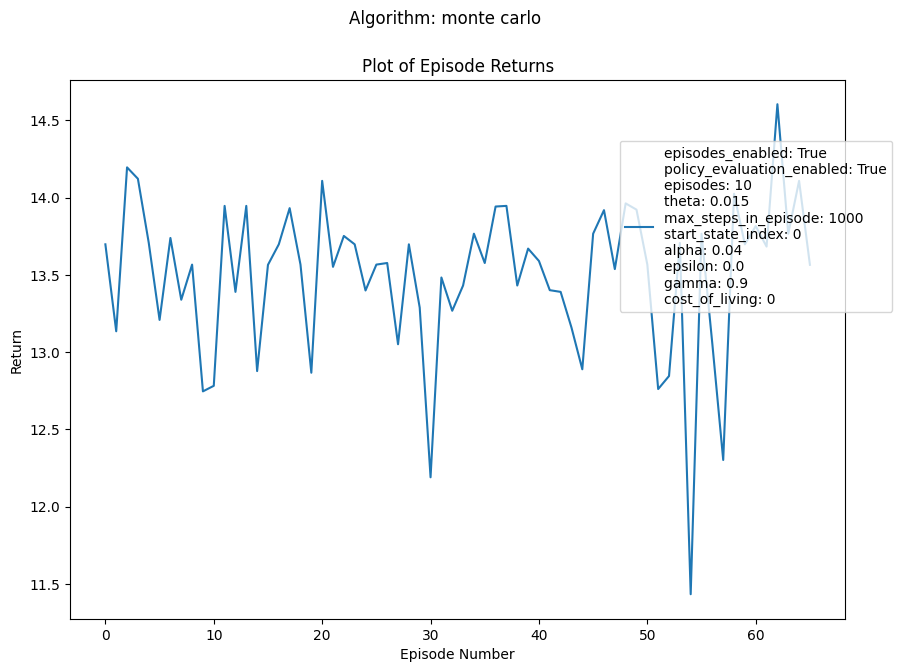

In [18]:
# monte carlo
solver.reset_solver()
solver.solve_with_monte_carlo(True, True,
                              episodes=10,
                              theta=0.015,
                              max_steps_in_episode=1000,
                              start_state_index=0,
                              alpha=0.04,
                              epsilon=0.00,
                              gamma=0.9,
                              cost_of_living=0
                              )
solver.create_plot_of_action_value_array()
solver.create_plot_of_episode_returns()

## Conclusion

The model is incorporating the test data, and the agent is learning the optimal path to achieve the goal, but the model need further testing on more diverse scenarios. The ground basics for the project has been laid out. When it comes to the Reinforcement Learning the project was really great experience that allowed for the "hands on" approach with the understanding of the underlying theoretical knowledge base behind it. All implemented concepts had their start within the theory, that was adapted to the real life scenario. Insight gained from this project will be a solid foundation for future development. In terms of possible future implementations the dynamic on demand calculation of States, Actions, Transition Probabilities and Rewards might be implemented to aid the performance and memory requirements. Right now the Model is capable of handling up to 200 different states with high performance, longer waiting times start with 300 states. The dynamic on demand calculation would reduce the memory consumption, by enabling algorithms to generate needed data based on the already defined formulas, thus improving performance.

## Additional Notes

## Future Improvements

The concept of this Report can be extended to compensate possible users with not just the optimal learning path for their goal, but also it could balance between user goal and the most optimal skills for the current market. This approach would mean sacrificing user expectations, for his own good and possible success.

### Alternative Course structure

For our project we have defined an MOOC course which is IT related. To show the possibilities this structure can offer we have also defined a math MOOC course constructed with different skills and courses to increase the understanding of said skills.

Defined math skills:

1. Arithmetic
2. Geometry
3. Algebra
4. Calculus
5. Statistics
6. Discrete Mathematics
7. Logic
8. Mathematical Analysis

Discriptive visualisation of the state: $(Arithmetic, Geometry, Algebra, Calculus, Statistics, Discrete Mathematics, Logic, Mathematical Analysis)$

### Seperate courses/modules:

#### Combo Modules
1. **Statistical Methods in Number Theory for Beginners**
	-  Requirements vector:
		- $r_{Arithmetic} = 1$
		- $r_{Statistics} = 1$
	- Upskill vector:
		- $u_{Arithmetic} = 2$
		- $u_{Statistics} = 2$
2. **Algebraic Statistics**
	-  Requirements vector:
		- $r_{Algebra} = 2$
		- $r_{Statistics} = 3$
	- Upskill vector:
		- $u_{Algebra} = 4$
		- $u_{Statistics} = 4$
3. **Discrete Geometry and Logic**
	- Requirements vector:
		- $r_{Algebra} = 2$
		- $r_{Geometry} = 2$
		- $r_{Discrete Mathematics} = 2$
		- $r_{Logic} = 2$
	- Upskill vector:
		- $u_{DiscreteMathematics} = 3$
		- $u_{Logic} = 3$
#### Arithmetic modules:
1. **Basic Arithmetic**
	- Requirements vector:
		- None
	- Upskill vector:
		- $u_{Arithmetic} = 3$
		- $u_{Geometry} = 1$
		- $u_{Algebra} = 1$
		- $u_{Calculus} = 1$

#### Algebra Modules
1. **Elementary Algebra 
	- Requirements vector:
		- None
	- Upskill vector:
		- $u_{Arithmetic} = 1$
		- $u_{Geometry} = 1$
		- $u_{Algebra} = 2$
2. **Intermediate Algebra:**
    - - Requirements vector:
		- $r_{Algebra} = 2$
		- $r_{Arithmetic} = 1$
		- $r_{Geometry} = 1$
	- Upskill vector:
		- $u_{Arithmetic} = 1$
		- $u_{Algebra} = 3$
3. **Linear Algebra:**
    - Requirements vector:
		- $r_{Algebra} = 5$
		- $r_{Arithmetic} = 3$
		- $r_{Geometry} = 3$
		- $r_{Calculus} = 2$
	- Upskill vector:
		- $u_{Arithmetic} = 1$
		- $u_{Geometry} = 1$
		- $u_{Algebra} = 3$

#### Geometry modules 
1. **Geometry:**
	- Requirements vector:
		- $r_{Arithmetic} = 1$
	- Upskill vector:
		- $u_{Arithmetic} = 2$
		- $u_{Geometry} = 2$
2. **Trigonometry:**
    - Requirements vector:
		- $r_{Arithmetic} = 3$
		- $r_{Geometry} = 2$
	- Upskill vector:
		- $u_{Arithmetic} = 2$
		- $u_{Geometry} = 3$

#### Calculus modules
1. **Pre-Calculus:**
    - Integrate algebra, geometry, and trigonometry to prepare for the study of calculus. Topics may include functions, limits, and basic mathematical modeling.
    - Requirements vector:
		- $r_{Arithmetic} = 1$
		- $r_{Geometry} = 1$
		- $r_{Algebra} = 1$
	- Upskill vector:
		- $u_{Arithmetic} = 2$
		- $u_{Calculus} = 2$
		- $u_{Geometry} = 2$
		- $u_{Algebra} = 1$
2. **Calculus:**
    - Start with differential calculus, covering concepts like limits, derivatives, and applications. Then progress to integral calculus, exploring integrals and their applications.
    - Requirements vector:
		- $r_{Arithmetic} = 2$
		- $r_{Geometry} = 2$
		- $r_{Algebra} = 2$
		- $r_{Calculus} = 2$
	- Upskill vector:
		- $u_{Arithmetic} = 1$
		- $u_{Calculus} = 3$
		- $u_{Geometry} = 1$
		- $u_{Algebra} = 1$
3. **Differential Equations:**
    - Study ordinary and partial differential equations and their applications in modeling real-world phenomena.
    - Requirements vector:
		- $r_{Arithmetic} = 5$
		- $r_{Geometry} = 3$
		- $r_{Algebra} = 3$
		- $r_{Calculus} = 5$
	- Upskill vector:
		- $u_{Arithmetic} = 1$
		- $u_{Calculus} = 4$
		- $u_{Geometry} = 1$
		- $u_{Algebra} = 1$

#### Statistics modules
1. Probability and Statistics
	- Understand the principles of probability theory and statistical analysis. This is crucial for data analysis and decision-making in various fields.
	- Requirements vector:
		- $r_{Algebra} = 2$
		- $r_{Arithmetic} = 2$
		- $r_{Statistics} = 1$
	- Upskill vector:
		- $u_{Arithmetic} = 1$
		- $u_{Statistics} = 3$

As you can see, a very extensive course structure can be build with this framework. The possibilities are endless.



### Unforeseen Discoveries in Project Development

#### Creating new formulas for the transition probabilites
![passed](passed.png "Title")
![not passed](not-passed.png "Title")

#### Redoing the same courses

While working on our project, we stumbled upon something quite unexpected. Our learning agent ended up taking the same course multiple times to reach its skill goal. It was a bit of a head-scratcher, something we hadn't really thought about in the beginning. This experience taught us that creating a learning system isn't as straightforward as it might seem at first. 

This unexpected behavior made us realize the importance of thinking about all possible situations right from the start. No matter how well we plan, there will always be surprises. It's like trying to predict everything a student might do, not an easy task!

This discovery also showed us that learning environments are kind of like puzzles. You have to make sure there are safeguards in place so things don't go off track. Testing our system in different situations became even more important.

In the end, our project not only gave us a cool new learning framework but also showed us that learning is full of surprises. It made us think harder about how our system works and how we can make it even better.